<a href="https://colab.research.google.com/github/trvslhlt/ift_6390_machine_learning/blob/practical-ex/practical_exercises/tp0_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP0: Les k plus proches voisins

**IFT6390 - Fondements de l'apprentissage machine**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pierrelux/mlbook/blob/main/exercises/tp0_knn.ipynb)

Ce notebook accompagne le [Chapitre 1: Methodes non parametriques](https://pierrelux.github.io/mlbook/drafts/knn).

## Objectifs

A la fin de ce TP, vous serez en mesure de:
- Comprendre l'algorithme des k plus proches voisins (k-ppv)
- Observer l'effet du parametre k sur les predictions
- Comparer differentes fonctions de distance
- Apprecier l'importance de la normalisation des donnees

---

## Partie 0: Configuration

Executez cette cellule pour importer les bibliotheques necessaires.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Pour de jolis graphiques
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['font.size'] = 12

print("Configuration terminee!")

Configuration terminee!


## Partie 1: L'algorithme k-ppv

L'idee des k plus proches voisins est simple: pour classifier un nouveau point, on regarde les $k$ points d'entrainement les plus proches et on prend un vote majoritaire.

### Les donnees

Commencons par generer un jeu de donnees de classification 2D.

In [ ]:
# Generation de donnees de classification
np.random.seed(42)
n_per_class = 15

# Classe 0: groupe autour de (-1, -1)
X0 = np.random.randn(n_per_class, 2) * 0.6 + np.array([-1, -1])
# Classe 1: groupe autour de (1, 1)
X1 = np.random.randn(n_per_class, 2) * 0.6 + np.array([1, 1])

X_train = np.vstack([X0, X1])
y_train = np.array([0] * n_per_class + [1] * n_per_class)

print(f"Nombre de points: {len(X_train)}")
print(f"Classes: {np.unique(y_train)}")

Nombre de points: 30
Classes: [0 1]


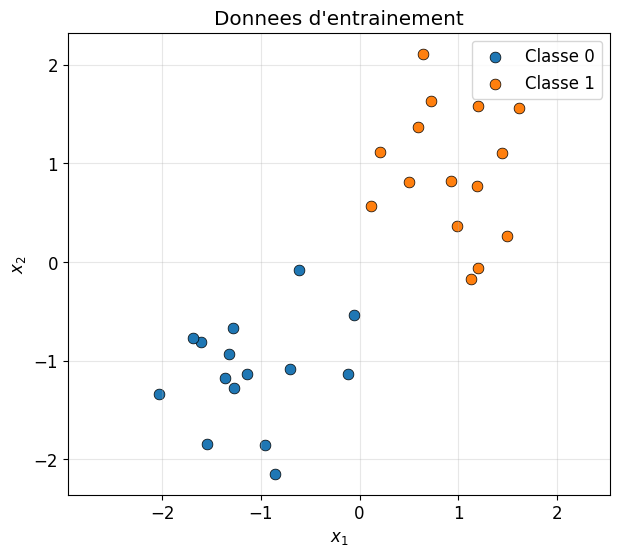

In [ ]:
# Visualisation des donnees
plt.figure(figsize=(7, 6))
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
           c='C0', s=60, label='Classe 0', edgecolors='k', linewidths=0.5)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
           c='C1', s=60, label='Classe 1', edgecolors='k', linewidths=0.5)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.title('Donnees d\'entrainement')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

### Visualiser les k voisins

Pour un point requete, identifions ses $k$ plus proches voisins.

In [ ]:
# Point requete
x_query = np.array([0.3, 0.2])
k = 5

# Calcul des distances euclidiennes
distances = np.sqrt(np.sum((X_train - x_query)**2, axis=1))

# Indices des k plus proches
k_nearest_idx = np.argsort(distances)[:k]

print(f"Point requete: {x_query}")
print(f"\nLes {k} plus proches voisins:")
for i, idx in enumerate(k_nearest_idx):
    print(f"  Voisin {i+1}: point {idx}, distance = {distances[idx]:.3f}, classe = {y_train[idx]}")

Point requete: [0.3 0.2]

Les 5 plus proches voisins:
  Voisin 1: point 22, distance = 0.413, classe = 1
  Voisin 2: point 28, distance = 0.645, classe = 1
  Voisin 3: point 16, distance = 0.711, classe = 1
  Voisin 4: point 3, distance = 0.819, classe = 0
  Voisin 5: point 21, distance = 0.884, classe = 1


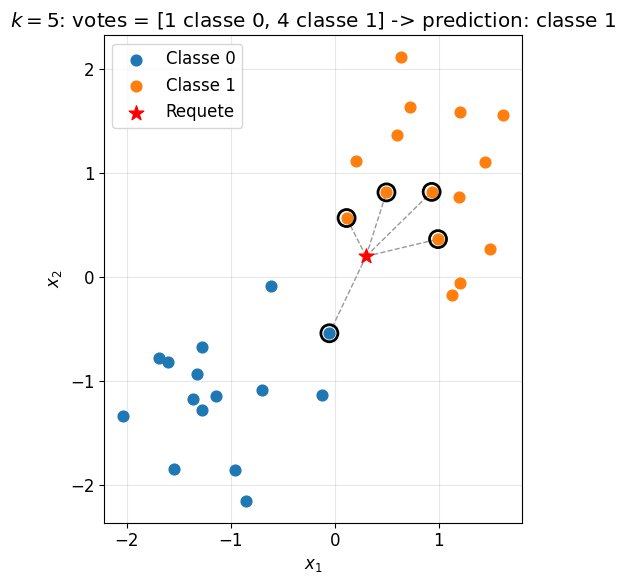

In [ ]:
# Visualisation des k voisins
fig, ax = plt.subplots(figsize=(7, 6))

# Points d'entrainement
ax.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
           c='C0', s=60, label='Classe 0', zorder=2)
ax.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
           c='C1', s=60, label='Classe 1', zorder=2)

# Lignes vers les k voisins et cercles autour
for idx in k_nearest_idx:
    ax.plot([x_query[0], X_train[idx, 0]], [x_query[1], X_train[idx, 1]],
            'k--', alpha=0.4, linewidth=1, zorder=1)
    ax.scatter(X_train[idx, 0], X_train[idx, 1],
               s=150, facecolors='none', edgecolors='black', linewidths=2, zorder=3)

# Point requete
ax.scatter(x_query[0], x_query[1], c='red', s=120, marker='*',
           label='Requete', zorder=4)

# Compter les votes
votes = y_train[k_nearest_idx]
n_class0 = np.sum(votes == 0)
n_class1 = np.sum(votes == 1)
prediction = 0 if n_class0 > n_class1 else 1

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.legend(loc='upper left')
ax.set_title(f'$k = {k}$: votes = [{n_class0} classe 0, {n_class1} classe 1] -> prediction: classe {prediction}')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Exercice: Implementer le vote majoritaire

Completez la fonction ci-dessous pour compter les votes et predire la classe.

In [ ]:
def knn_predict(X_train, y_train, x_query, k):
    """
    Predit la classe d'un point en utilisant les k plus proches voisins.

    Parametres:
        X_train: array (N, d) - points d'entrainement
        y_train: array (N,) - etiquettes (0 ou 1)
        x_query: array (d,) - point a classifier
        k: int - nombre de voisins

    Retourne:
        prediction: int (0 ou 1)
    """
    # TODO: Calculer les distances euclidiennes de x_query a tous les points
    distances = np.sqrt(np.sum((X_train - x_query) ** 2, axis=1))  # A completer

    # TODO: Trouver les indices des k plus proches voisins
    k_nearest_idx = np.argsort(distances)[:k]  # A completer

    # TODO: Recuperer les etiquettes des k voisins
    k_labels = y_train[k_nearest_idx]  # A completer

    # TODO: Vote majoritaire (retourner 0 ou 1)
    prediction = 1 if np.sum(k_labels) > k/2 else 0  # A completer

    return prediction

# Test de votre fonction
test_pred = knn_predict(X_train, y_train, x_query, k=5)
print(f"Prediction pour {x_query}: classe {test_pred}")

Prediction pour [0.3 0.2]: classe 1


<details>
<summary><b>Solution</b> (cliquez pour afficher)</summary>

```python
def knn_predict(X_train, y_train, x_query, k):
    # Calculer les distances euclidiennes
    distances = np.sqrt(np.sum((X_train - x_query)**2, axis=1))
    
    # Trouver les indices des k plus proches voisins
    k_nearest_idx = np.argsort(distances)[:k]
    
    # Recuperer les etiquettes des k voisins
    k_labels = y_train[k_nearest_idx]
    
    # Vote majoritaire
    prediction = 1 if np.sum(k_labels) > k/2 else 0
    
    return prediction
```
</details>

---
## Partie 2: Effet de k

Le parametre $k$ controle la complexite du modele:
- **$k=1$**: Frontiere tres irreguliere, erreur d'entrainement = 0
- **Grand $k$**: Frontiere plus lisse, tend vers la classe majoritaire

Visualisons la frontiere de decision pour differentes valeurs de $k$.

In [ ]:
def knn_predict_batch(X_train, y_train, X_test, k):
    """Predit les classes pour un ensemble de points."""
    predictions = []
    for x in X_test:
        distances = np.sqrt(np.sum((X_train - x)**2, axis=1))
        k_nearest_idx = np.argsort(distances)[:k]
        k_labels = y_train[k_nearest_idx]
        predictions.append(1 if np.sum(k_labels) > k/2 else 0)
    return np.array(predictions)

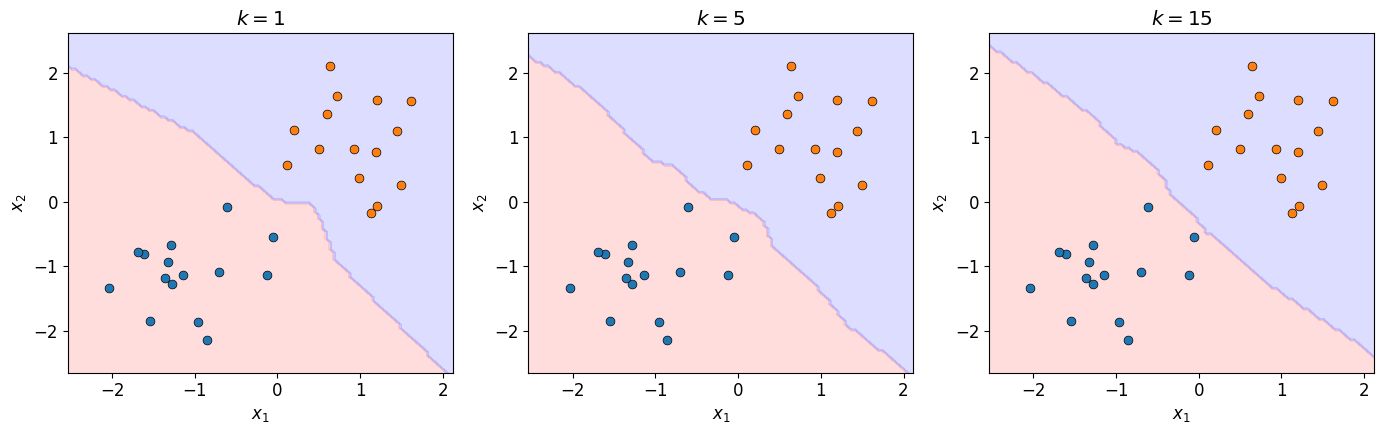

In [ ]:
# Creer une grille pour visualiser la frontiere de decision
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
X_mesh = np.c_[xx.ravel(), yy.ravel()]

# Visualiser pour differentes valeurs de k
fig, axes = plt.subplots(1, 3, figsize=(14, 4.5))
k_values = [1, 5, 15]
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])

for ax, k in zip(axes, k_values):
    Z = knn_predict_batch(X_train, y_train, X_mesh, k)
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)
    ax.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
               c='C0', s=40, edgecolors='k', linewidths=0.5)
    ax.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
               c='C1', s=40, edgecolors='k', linewidths=0.5)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f'$k = {k}$')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

plt.tight_layout()
plt.show()

**Question**: Que se passe-t-il avec $k=1$? Et avec $k=N$ (tous les points)?

### Compromis biais-variance

Tracez l'erreur d'entrainement et de test en fonction de $k$.

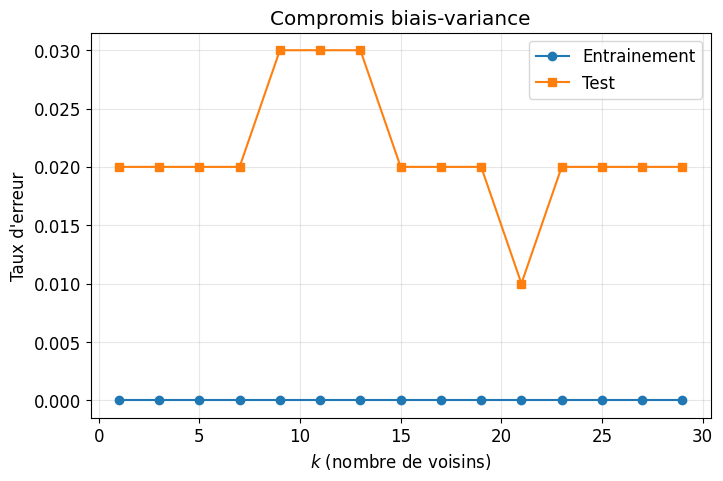

Meilleur k sur le test: 21


In [ ]:
# Generer des donnees de test
np.random.seed(123)
X0_test = np.random.randn(50, 2) * 0.6 + np.array([-1, -1])
X1_test = np.random.randn(50, 2) * 0.6 + np.array([1, 1])
X_test = np.vstack([X0_test, X1_test])
y_test = np.array([0] * 50 + [1] * 50)

# Calculer les erreurs pour differents k
k_values = list(range(1, 30, 2))  # k impair pour eviter les egalites
train_errors = []
test_errors = []

for k in k_values:
    y_pred_train = knn_predict_batch(X_train, y_train, X_train, k)
    y_pred_test = knn_predict_batch(X_train, y_train, X_test, k)
    train_errors.append(np.mean(y_pred_train != y_train))
    test_errors.append(np.mean(y_pred_test != y_test))

# Tracer
plt.figure(figsize=(8, 5))
plt.plot(k_values, train_errors, 'o-', label='Entrainement')
plt.plot(k_values, test_errors, 's-', label='Test')
plt.xlabel('$k$ (nombre de voisins)')
plt.ylabel('Taux d\'erreur')
plt.title('Compromis biais-variance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Meilleur k sur le test: {k_values[np.argmin(test_errors)]}")

---
## Partie 3: Fonctions de distance

L'algorithme k-ppv depend de la fonction de distance utilisee. Les plus communes sont:

- **Distance euclidienne ($\ell_2$)**: $d(\mathbf{x}, \mathbf{y}) = \sqrt{\sum_j (x_j - y_j)^2}$
- **Distance de Manhattan ($\ell_1$)**: $d(\mathbf{x}, \mathbf{y}) = \sum_j |x_j - y_j|$
- **Distance $\ell_\infty$**: $d(\mathbf{x}, \mathbf{y}) = \max_j |x_j - y_j|$

### Visualiser les boules unite

La forme de la boule unite montre ce que chaque norme considere comme "equidistant".

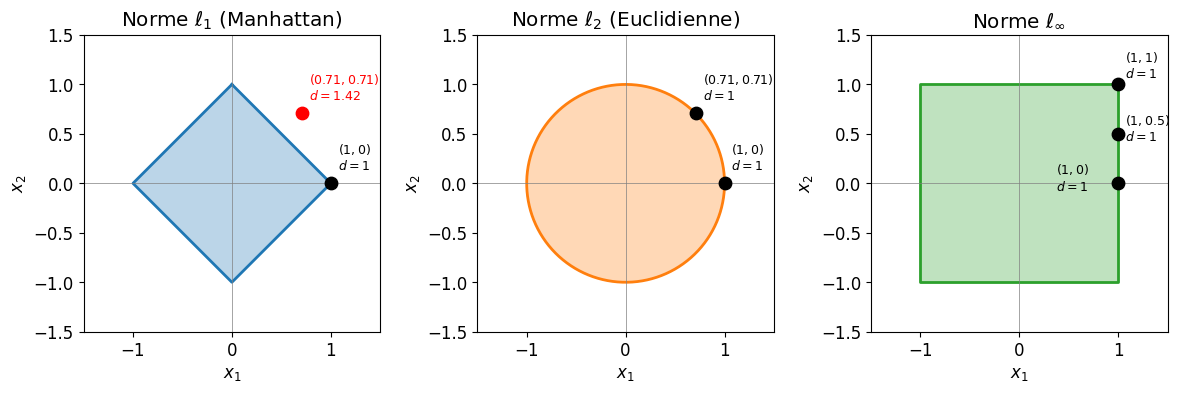

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Points de reference
p1 = (1, 0)
p2 = (1/np.sqrt(2), 1/np.sqrt(2))  # ~(0.71, 0.71)

# L1 norm (losange)
ax = axes[0]
t = np.linspace(0, 1, 250)
x_l1 = np.concatenate([t, 1-t, -t, -1+t])
y_l1 = np.concatenate([1-t, -t, -1+t, t])
ax.fill(x_l1, y_l1, alpha=0.3, color='C0')
ax.plot(x_l1, y_l1, 'C0-', linewidth=2)

ax.scatter([p1[0]], [p1[1]], s=80, c='black', zorder=5)
ax.scatter([p2[0]], [p2[1]], s=80, c='red', zorder=5)
ax.annotate(f'$(1, 0)$\n$d=1$', p1, textcoords='offset points',
            xytext=(5, 10), fontsize=9)
ax.annotate(f'$(0.71, 0.71)$\n$d=1.42$', p2, textcoords='offset points',
            xytext=(5, 10), fontsize=9, color='red')

ax.set_title(r'Norme $\ell_1$ (Manhattan)')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

# L2 norm (cercle)
ax = axes[1]
theta = np.linspace(0, 2*np.pi, 1000)
x_l2 = np.cos(theta)
y_l2 = np.sin(theta)
ax.fill(x_l2, y_l2, alpha=0.3, color='C1')
ax.plot(x_l2, y_l2, 'C1-', linewidth=2)

ax.scatter([p1[0]], [p1[1]], s=80, c='black', zorder=5)
ax.scatter([p2[0]], [p2[1]], s=80, c='black', zorder=5)
ax.annotate(f'$(1, 0)$\n$d=1$', p1, textcoords='offset points',
            xytext=(5, 10), fontsize=9)
ax.annotate(f'$(0.71, 0.71)$\n$d=1$', p2, textcoords='offset points',
            xytext=(5, 10), fontsize=9)

ax.set_title(r'Norme $\ell_2$ (Euclidienne)')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

# L-infinity norm (carre)
ax = axes[2]
x_linf = np.array([1, 1, -1, -1, 1])
y_linf = np.array([1, -1, -1, 1, 1])
ax.fill(x_linf, y_linf, alpha=0.3, color='C2')
ax.plot(x_linf, y_linf, 'C2-', linewidth=2)

# Pour L-inf: (1,0), (1,0.5), (1,1) ont tous distance 1
p_inf = [(1, 0), (1, 0.5), (1, 1)]
for i, p in enumerate(p_inf):
    ax.scatter([p[0]], [p[1]], s=80, c='black', zorder=5)
ax.annotate('$(1, 0)$\n$d=1$', p_inf[0], textcoords='offset points',
            xytext=(-45, -5), fontsize=9)
ax.annotate('$(1, 0.5)$\n$d=1$', p_inf[1], textcoords='offset points',
            xytext=(5, -5), fontsize=9)
ax.annotate('$(1, 1)$\n$d=1$', p_inf[2], textcoords='offset points',
            xytext=(5, 5), fontsize=9)

ax.set_title(r'Norme $\ell_\infty$')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.tight_layout()
plt.show()

### Exercice: Calculer les distances

Implementez les trois fonctions de distance.

In [ ]:
def distance_l1(x, y):
    """Distance de Manhattan."""
    return np.sum(np.abs(x - y))

def distance_l2(x, y):
    """Distance euclidienne."""
    return np.sqrt(np.sum((x - y) ** 2))

def distance_linf(x, y):
    """Distance L-infini."""
    # largest single-dimension difference
    return np.max(np.abs(x- y))

# Test avec deux points
x = np.array([0, 0])
y = np.array([3, 4])

print(f"Points: x = {x}, y = {y}")
print(f"Distance L1: {distance_l1(x, y)}")     # Attendu: 7
print(f"Distance L2: {distance_l2(x, y)}")     # Attendu: 5
print(f"Distance L-inf: {distance_linf(x, y)}") # Attendu: 4

Points: x = [0 0], y = [3 4]
Distance L1: 7
Distance L2: 5.0
Distance L-inf: 4


<details>
<summary><b>Solution</b> (cliquez pour afficher)</summary>

```python
def distance_l1(x, y):
    return np.sum(np.abs(x - y))

def distance_l2(x, y):
    return np.sqrt(np.sum((x - y)**2))

def distance_linf(x, y):
    return np.max(np.abs(x - y))
```
</details>

### Comment les voisins changent selon la distance

Visualisons comment le choix de la metrique affecte les voisins selectionnes.

<>:16: SyntaxWarning: invalid escape sequence '\i'
<>:16: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-2483767583.py:16: SyntaxWarning: invalid escape sequence '\i'
  metrics = [('$\\ell_1$', distance_l1), ('$\\ell_2$', distance_l2), ('$\\ell_\infty$', distance_linf)]


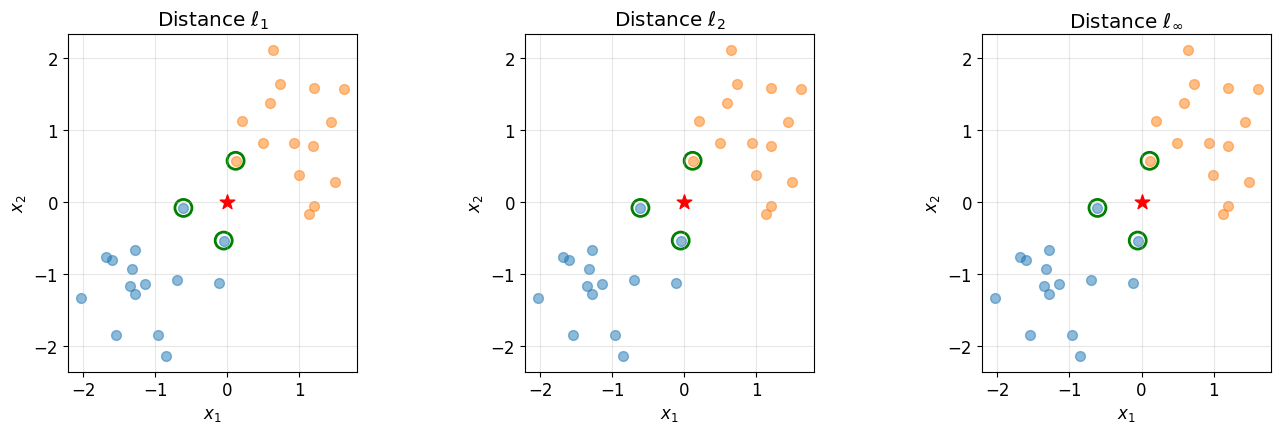

In [ ]:
# Implementer les fonctions de distance (solution)
def distance_l1(x, y):
    return np.sum(np.abs(x - y))

def distance_l2(x, y):
    return np.sqrt(np.sum((x - y)**2))

def distance_linf(x, y):
    return np.max(np.abs(x - y))

# Point requete
x_q = np.array([0, 0])
k = 3

fig, axes = plt.subplots(1, 3, figsize=(14, 4.5))
metrics = [('$\\ell_1$', distance_l1), ('$\\ell_2$', distance_l2), ('$\\ell_\infty$', distance_linf)]

for ax, (name, dist_func) in zip(axes, metrics):
    # Calculer les distances avec cette metrique
    distances = np.array([dist_func(x_q, xi) for xi in X_train])
    k_idx = np.argsort(distances)[:k]

    ax.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
               c='C0', s=50, alpha=0.5)
    ax.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
               c='C1', s=50, alpha=0.5)

    # Mettre en evidence les k voisins
    for idx in k_idx:
        ax.scatter(X_train[idx, 0], X_train[idx, 1],
                   s=150, facecolors='none', edgecolors='green', linewidths=2)

    ax.scatter(x_q[0], x_q[1], c='red', s=120, marker='*', zorder=5)
    ax.set_title(f'Distance {name}')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Partie 4: Importance de la normalisation

Quand les variables ont des echelles differentes, certaines dominent le calcul de distance.

### Exemple: age vs revenu

In [ ]:
# Donnees: age (20-70) et revenu (20000-200000)
np.random.seed(42)
n = 30

# Generer des donnees realistes
ages = np.random.uniform(25, 65, n)
revenus = ages * 2000 + np.random.normal(0, 20000, n) + 30000  # Correlation avec l'age

X_raw = np.column_stack([ages, revenus])

# Etiquettes basees sur une combinaison non-lineaire
y_raw = ((ages > 45) | (revenus > 100000)).astype(int)

print(f"Age: min={ages.min():.1f}, max={ages.max():.1f}")
print(f"Revenu: min={revenus.min():.0f}, max={revenus.max():.0f}")

Age: min=25.8, max=63.8
Revenu: min=74048, max=163571


In [ ]:
# Calculer les distances avant normalisation
x1 = np.array([30, 50000])   # Jeune, revenu moyen
x2 = np.array([35, 51000])   # Similaire en age, revenu proche
x3 = np.array([31, 150000])  # Age proche, revenu tres different

d_12 = np.sqrt(np.sum((x1 - x2)**2))
d_13 = np.sqrt(np.sum((x1 - x3)**2))

print("AVANT normalisation:")
print(f"  Distance x1-x2 (age: +5 ans, revenu: +1000$): {d_12:.1f}")
print(f"  Distance x1-x3 (age: +1 an, revenu: +100000$): {d_13:.1f}")
print(f"  Ratio: {d_13/d_12:.1f}x plus loin")

AVANT normalisation:
  Distance x1-x2 (age: +5 ans, revenu: +1000$): 1000.0
  Distance x1-x3 (age: +1 an, revenu: +100000$): 100000.0
  Ratio: 100.0x plus loin


**Observation**: La difference de revenu domine completement! Une difference de 100000$ est vue comme 100x plus importante qu'une difference de 5 ans.

In [ ]:
# Normalisation: centrer et reduire
mean_age = ages.mean()
std_age = ages.std()
mean_rev = revenus.mean()
std_rev = revenus.std()

def normalize(x):
    return np.array([(x[0] - mean_age) / std_age,
                     (x[1] - mean_rev) / std_rev])

x1_norm = normalize(x1)
x2_norm = normalize(x2)
x3_norm = normalize(x3)

d_12_norm = np.sqrt(np.sum((x1_norm - x2_norm)**2))
d_13_norm = np.sqrt(np.sum((x1_norm - x3_norm)**2))

print("APRES normalisation:")
print(f"  Distance x1-x2: {d_12_norm:.3f}")
print(f"  Distance x1-x3: {d_13_norm:.3f}")
print(f"  Ratio: {d_13_norm/d_12_norm:.1f}x plus loin")

APRES normalisation:
  Distance x1-x2: 0.453
  Distance x1-x3: 4.574
  Ratio: 10.1x plus loin


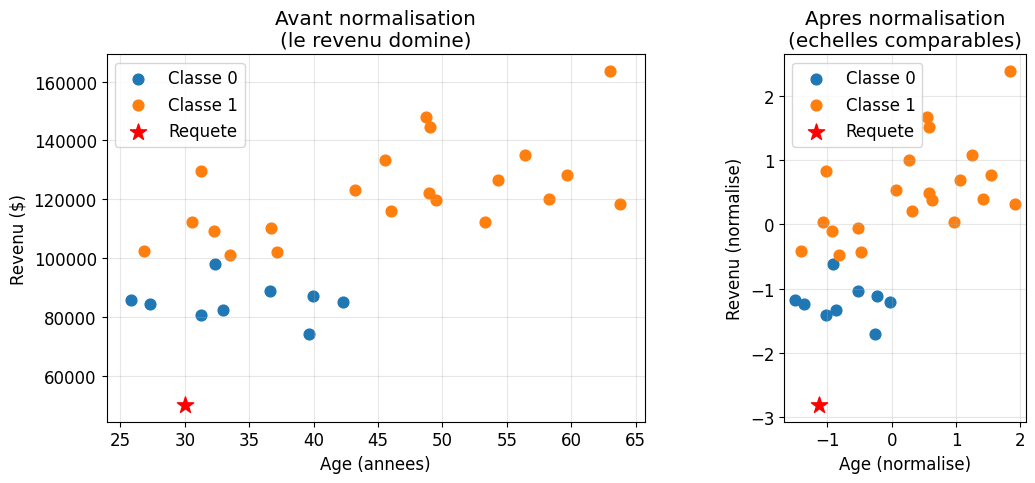

In [ ]:
# Visualiser l'effet de la normalisation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Avant normalisation
ax = axes[0]
ax.scatter(X_raw[y_raw == 0, 0], X_raw[y_raw == 0, 1], c='C0', s=60, label='Classe 0')
ax.scatter(X_raw[y_raw == 1, 0], X_raw[y_raw == 1, 1], c='C1', s=60, label='Classe 1')
ax.scatter([x1[0]], [x1[1]], c='red', s=150, marker='*', zorder=5, label='Requete')
ax.set_xlabel('Age (annees)')
ax.set_ylabel('Revenu ($)')
ax.set_title('Avant normalisation\n(le revenu domine)')
ax.legend()
ax.grid(True, alpha=0.3)

# Apres normalisation
X_norm = np.column_stack([(ages - mean_age) / std_age,
                          (revenus - mean_rev) / std_rev])

ax = axes[1]
ax.scatter(X_norm[y_raw == 0, 0], X_norm[y_raw == 0, 1], c='C0', s=60, label='Classe 0')
ax.scatter(X_norm[y_raw == 1, 0], X_norm[y_raw == 1, 1], c='C1', s=60, label='Classe 1')
ax.scatter([x1_norm[0]], [x1_norm[1]], c='red', s=150, marker='*', zorder=5, label='Requete')
ax.set_xlabel('Age (normalise)')
ax.set_ylabel('Revenu (normalise)')
ax.set_title('Apres normalisation\n(echelles comparables)')
ax.legend()
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Question**: Quelle variable domine le calcul de distance sans normalisation? Pourquoi est-ce problematique pour k-ppv?

---
## Recapitulatif

Dans ce TP, vous avez appris:

1. **Algorithme k-ppv**: Classifier par vote majoritaire des k voisins les plus proches

2. **Effet de k**:
   - Petit k = frontiere irreguliere (haute variance)
   - Grand k = frontiere lisse (haut biais)
   
3. **Fonctions de distance**: $\ell_1$ (Manhattan), $\ell_2$ (Euclidienne), $\ell_\infty$
   - La forme de la boule unite definit ce qui est "equidistant"

4. **Normalisation**: Indispensable quand les variables ont des echelles differentes

---

**Pour aller plus loin**: [Chapitre complet sur le site du cours](https://pierrelux.github.io/mlbook/drafts/knn)